In [1]:
import pandas as pd

df = pd.read_csv("fisheries_with_pace_kd_Edz_AVW_PAR.csv")
print(df.columns)

metadata_cols = ['TOWDATETIME_EST', 'LAT', 'LON', 'MEAN_DEPTH', 'AVW_Edz', 'Edz_trapz', 'Edz_trapz_log', 'SWEPT_AREA_KM']
edz_cols = [col for col in df.columns if col.startswith("Edz_")]
species_cols = [col for col in df.columns if col not in metadata_cols + edz_cols]

df2 = pd.read_csv("fisheries_with_pace_rrs_avw.csv")
metadata_cols2 = ['TOWDATETIME_EST', 'LAT', 'LON', 'MEAN_DEPTH', 'AVW', 'SWEPT_AREA_KM']
rrs_cols = [col for col in df2.columns if col.startswith("Rrs_")]

Index(['TOWDATETIME_EST', 'LAT', 'LON', 'MEAN_DEPTH', 'SWEPT_AREA_km',
       'acadian redfish', 'alewife', 'alligatorfish', 'american lobster',
       'american plaice',
       ...
       'Edz_583', 'Edz_618', 'Edz_640', 'Edz_655', 'Edz_665', 'Edz_678',
       'Edz_711', 'Edz_trapz', 'Edz_trapz_log', 'AVW_Edz'],
      dtype='object', length=239)


In [10]:
y

0      0.557520
1      0.440212
2      0.522318
3      0.812897
4      0.262523
         ...   
363    1.042000
364   -0.646078
365   -4.390971
366   -1.277464
367   -0.862291
Name: Edz_trapz_log, Length: 331, dtype: float64

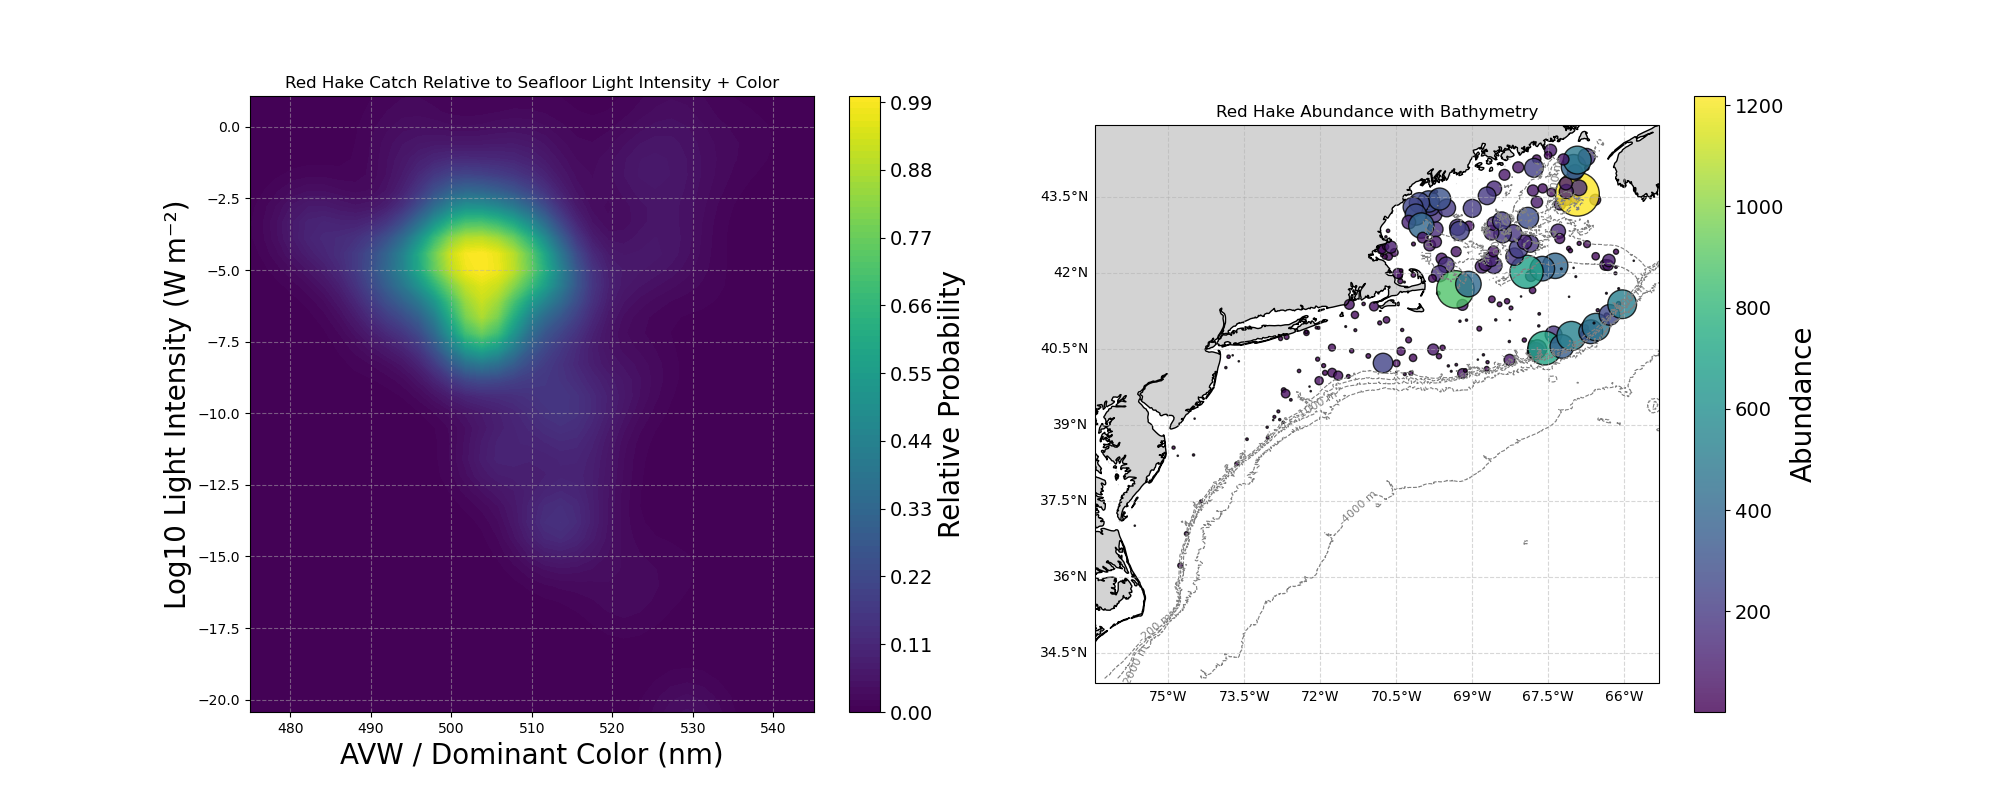

In [2]:
#plt.close()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

# === Choose your species ===
#species = "butterfish" #diurnal migrator
species = "red hake" 
species_filename = species.lower().replace(" ", "_")  # becomes 'longfin_squid'

# Make sure df["AVW"] is filled from df2
df["AVW"] = df2["AVW"]

# Drop rows where any of the key columns are NaN
subset1 = df[["AVW", "Edz_trapz_log", species]].dropna()

# Extract arrays (aligned and clean)
x = subset1["AVW"].to_numpy()
y = subset1["Edz_trapz_log"].to_numpy()
z = subset1[species].to_numpy()

n_bins = 40
stat, xedges, yedges, _ = binned_statistic_2d(x, y, z, statistic='sum', bins=n_bins)
stat_filled = np.nan_to_num(stat, nan=0.0)
stat_smooth = gaussian_filter(stat_filled, sigma=1.8)
stat_normalized = stat_smooth / stat_smooth.max()

X, Y = np.meshgrid(
    0.5 * (xedges[:-1] + xedges[1:]),
    0.5 * (yedges[:-1] + yedges[1:])
)

# === 2. Preprocess for map plot ===
subset2 = df[["LAT", "LON", species]].dropna()
subset2 = subset2[subset2[species] > 0]

size_scale = 1000
sizes = (subset2[species] / subset2[species].max()) * size_scale

# Load bathymetry data
gebco = xr.open_dataset("gebco_2024.nc")
lon_bathy = gebco["lon"]
lat_bathy = gebco["lat"]
depth = gebco["elevation"]

# Calculate extent based on species data
lat_min = df["LAT"].min() - 0.5
lat_max = df["LAT"].max() + 0.5
lon_min = df["LON"].min() - 0.5
lon_max = df["LON"].max() + 0.5

%matplotlib widget
# === Create side-by-side figure ===
fig = plt.figure(figsize=(20, 8))

# === Left subplot: AVW vs Rrs Brightness ===
ax1 = fig.add_subplot(1, 2, 1)
#p1 = ax1.pcolormesh(X, Y, stat_normalized.T, cmap="viridis", shading="auto")
p1 = ax1.contourf(X, Y, stat_normalized.T,levels=100, cmap="viridis")
ax1.set_xlabel("AVW / Dominant Color (nm)", fontsize=20)
ax1.set_ylabel("Log10 Light Intensity (W m⁻²)", fontsize=20)
ax1.set_title(f"{species.title()} Catch Relative to Seafloor Light Intensity + Color")
#ax1.set_ylim(df["Rrs_brightness"].min(), 1.4)
ax1.set_xlim(475, 545)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
cbar = fig.colorbar(p1, ax=ax1, label="Relative Probability")
cbar.ax.tick_params(labelsize=14)           # Tick labels on colorbar
cbar.set_label("Relative Probability", fontsize=20)  # Label of colorbar

# === Right subplot: Map with Bathymetry ===
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

sc = ax2.scatter(
    subset2["LON"], subset2["LAT"], c=subset2[species],
    cmap="viridis", s=sizes, edgecolor="k", alpha=0.8,
    transform=ccrs.PlateCarree()
)

contour_levels = [-4000, -2000, -1000, -500, -200]
cs = ax2.contour(
    lon_bathy, lat_bathy, depth,
    levels=contour_levels, colors='gray', linewidths=0.8,
    transform=ccrs.PlateCarree()
)
ax2.clabel(cs, inline=True, fontsize=8, fmt='%d m')
ax2.coastlines()
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.set_title(f"{species.title()} Abundance with Bathymetry")

# Add gridlines and labels
gl = ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}
# Optional: control tick spacing
# gl.xlocator = plt.MaxNLocator(5)
# gl.ylocator = plt.MaxNLocator(5)

cbar2 = fig.colorbar(sc, ax=ax2)
cbar2.set_label("Abundance", fontsize=20)
cbar2.ax.tick_params(labelsize=14)
#plt.savefig(f"{species_filename}_distribution.png", dpi=300)

plt.show()

In [3]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = ("2024-04-01", "2024-04-30"),
    granule_name="*.MO.*.4km.*"
)
fileset = earthaccess.open(results);

results2 = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_AVW",
    temporal = ("2024-04-01", "2024-04-30"),
    granule_name="*.MO.*.4km.*"
)
fileset2 = earthaccess.open(results2);    

# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid

# Load relevant datasets
dataset = xr.open_dataset(fileset[0])
dataset2 = xr.open_dataset(fileset2[0])

# Assign core variables
latitude = dataset["lat"]
longitude = dataset["lon"]
Kd = dataset["Kd"]
wavelengths = dataset["wavelength"]
avw = dataset2["avw"]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Define lat/lon bounds for your plot region
lat_bounds = [45.0, 34.0] 
lon_bounds = [-77.0, -65.0]

# Step 1: Subset spatially and spectrally (BEFORE .values)
Kd_subset = Kd.sel(
    lat=slice(*lat_bounds),
    lon=slice(*lon_bounds),
)

avw_subset = avw.sel(
    lat=slice(*lat_bounds),
    lon=slice(*lon_bounds),
)


wl_subset = Kd_subset["wavelength"].values  # shape: (n_wl,)

# Step 2: Convert to NumPy (now much smaller)
Kd_np = Kd_subset.values  # shape: (lat, lon, n_wl)

# === Load surface Es spectrum (matched to PAE wavelengths) ===
df_es = pd.read_csv('Es_spectrum.csv')  # should have 'wave' and 'Es' columns
wave_Es = df_es['wave'].values  # e.g., [412, 443, ...]
Es = df_es['Es'].values         # same length as kd_cols

# Bring in bathymetry 
# Load bathymetry data
gebco = xr.open_dataset("gebco_2024.nc")
lon_bathy = gebco["lon"]
lat_bathy = gebco["lat"]
depth = gebco["elevation"]

# Interpolate GEBCO depth to match PACE Kd lat/lon grid
# GEBCO elevation: land is > 0, ocean is < 0
# So first interpolate to match Kd grid:
depth_interp = depth.interp(lon=Kd_subset.lon, lat=Kd_subset.lat)

# Flip sign: ocean depths positive
bottom_depth = -depth_interp

# Mask out land (elevations ≥ 0 in original = depth ≤ 0 after flip)
bottom_depth = xr.where(bottom_depth > 0, bottom_depth, np.nan)

# Align shapes: (lat, lon) -> (lat, lon, wavelength) to ensure dimension order matches Kd_subset
depth_3d = bottom_depth.expand_dims(wavelength=Kd_subset.wavelength)
depth_3d = depth_3d.transpose("lat", "lon", "wavelength")

# Expand Es to shape: (1, 1, n_wl)
Es_expanded = Es[np.newaxis, np.newaxis, :]

# Calculate Kd * depth
attenuation = Kd_subset.values * depth_3d.values  # shape: (lat, lon, wl)

# Clip attenuation values to avoid overflow (np.exp overflows ~709)
attenuation_clipped = np.clip(attenuation, 0, 700)

# Compute Edz safely
Edz_bottom = Es_expanded * np.exp(-attenuation_clipped)

Edz_xr = xr.DataArray(
    Edz_bottom,
    coords=Kd_subset.coords,
    dims=Kd_subset.dims,
    name="Edz_bottom"
)

#Integrate over wavelength (axis=2 now); normalize to surface irradiance (352.8751)
PARz = (Edz_xr.integrate(coord="wavelength"))

avw_subset = xr.where(
    (PARz >= 1e-9) | np.isnan(avw_subset),  # keep if PARz is high *or* AVWz is NaN
    avw_subset,                             # keep original value
    0                                 # otherwise, set to 0
)


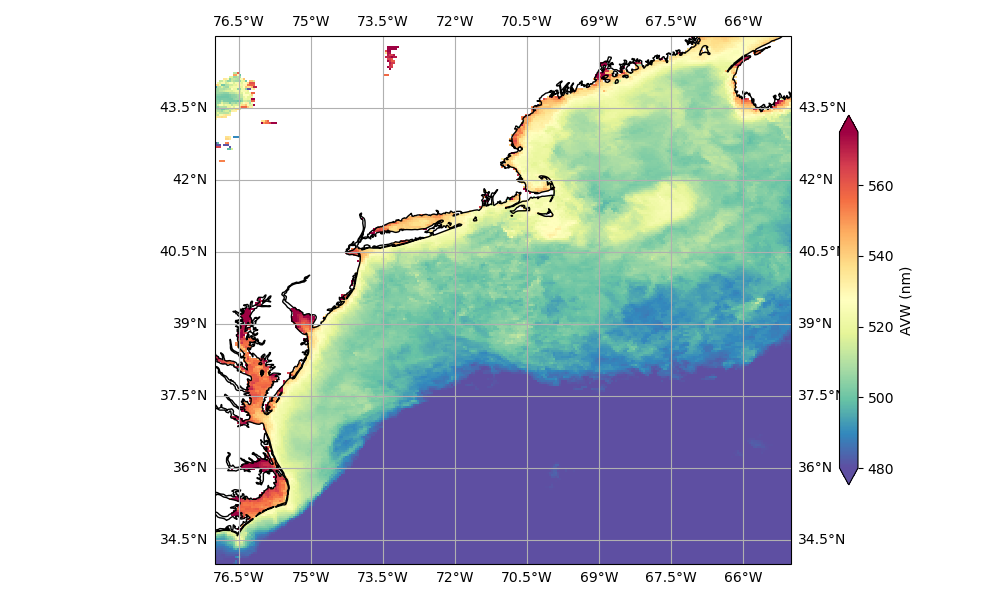

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a figure with 1 subplot (you can expand to more if needed)
fig, axes = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# If only one subplot, axes is not a list—so just use ax directly
ax1 = axes
ax1.set_title("AVW (nm)", fontsize=14)
ax1.coastlines()
ax1.gridlines(draw_labels=True)

# Plot AVW subset using xarray's plot API
plot1 = avw.plot(
    ax=ax1,
    x="lon",
    y="lat",
    cmap="Spectral_r",
    vmin=480,
    vmax=575,
    add_colorbar=True,
    cbar_kwargs={'label': 'AVW (nm)', 'shrink': 0.7}
)

# Set plot extent
ax1.set_xlim(-77.0, -65.0)
ax1.set_ylim(34.0, 45.0)

plt.tight_layout()
plt.show()


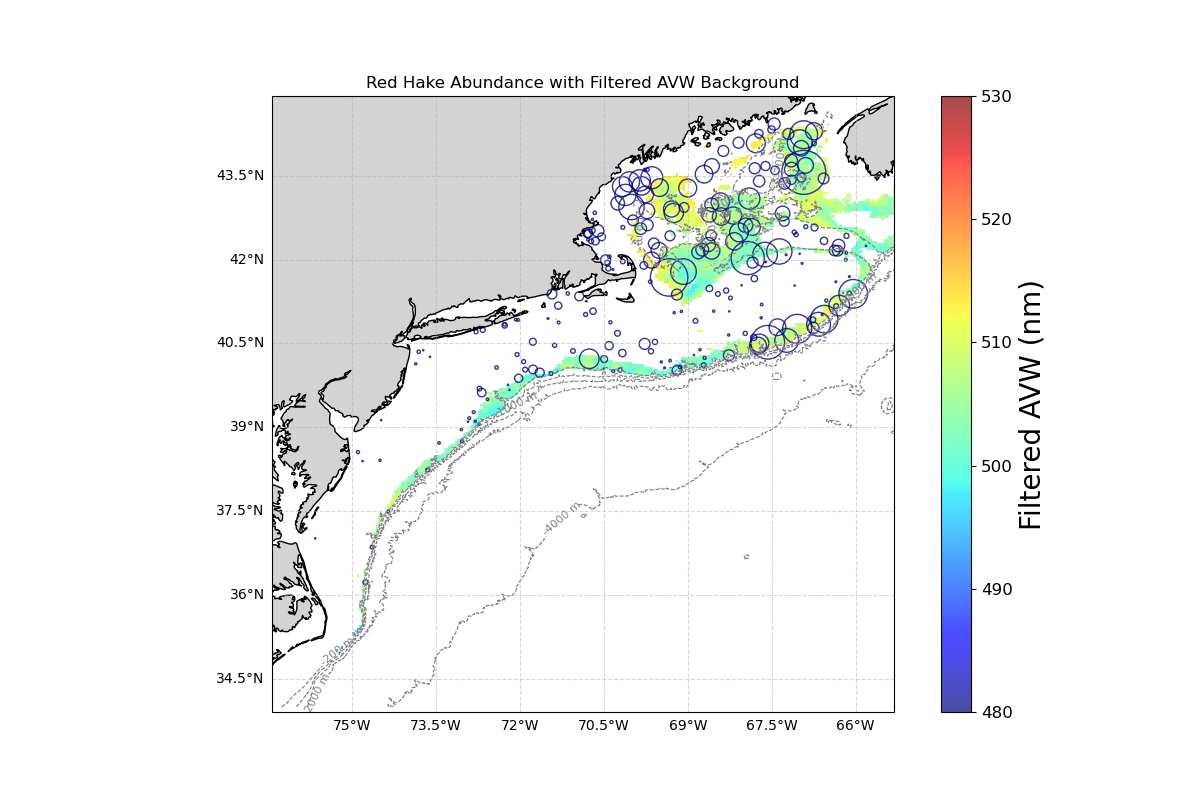

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

PARz_log = np.log10(PARz)

# Assuming avw_filtered is an xarray.DataArray with dims ('lat', 'lon')

# === Apply filters ===
#vw_mask = (avw_subset >= 500) & (avw_subset <= 510) #longfin squid
#avw_mask = (avw_subset >= 498) & (avw_subset <= 510) #red hake
#avw_mask = (avw_subset >= 498) & (avw_subset <= 505) #spiny dogfish
#avw_mask = (avw_subset >= 500) & (avw_subset <= 520) #american lobster
#avw_mask = (avw_subset >=545) & (avw_subset <= 555) #alewife
#avw_mask = (avw_subset >= 500) & (avw_subset <= 510) #silver hake 
avw_mask = (avw_subset >= 490) & (avw_subset <= 515) #spiny dogfish

#brightness_mask = (rrs_integrated_da >= 0.35) & (rrs_integrated_da <= 0.55)
#brightness_mask = (rrs_integrated_da >= 0.45) & (rrs_integrated_da <= 0.95)
#brightness_mask = (rrs_integrated_da >= 0.35) & (rrs_integrated_da <= 0.50)
#brightness_mask = (rrs_integrated_da >= 0.3) & (rrs_integrated_da <= 0.5)
#brightness_mask = (rrs_integrated_da >= 0.4) & (rrs_integrated_da <= 0.6)
#brightness_mask = (rrs_integrated_da >= 0.30) & (rrs_integrated_da <= 0.50)
brightness_mask = ((PARz_log >= -8) & (PARz_log <= -2.5))


valid_mask = avw_mask & brightness_mask

# Mask avw values for plotting
avw_filtered = avw_subset.where(valid_mask)


fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to your data or desired bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot avw_filtered as a background image
# Use cmap and alpha for better overlay
im = avw_filtered.plot(
    ax=ax,
    x='lon',
    y='lat',
    cmap='jet',
    vmin=480,
    vmax=530,
    alpha=0.7,
    add_colorbar=True,
    cbar_kwargs={'label': 'Filtered AVW (nm)'}
)

cbar = im.colorbar
cbar.set_label('Filtered AVW (nm)', fontsize=20)
cbar.ax.tick_params(labelsize=12)

# Plot bathymetry contours as before
contour_levels = [-4000, -2000, -1000, -500, -200]
cs = ax.contour(
    lon_bathy, lat_bathy, depth,
    levels=contour_levels, colors='gray', linewidths=0.8,
    transform=ccrs.PlateCarree()
)
ax.clabel(cs, inline=True, fontsize=8, fmt='%d m')

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Scatter points with fixed color (e.g., dark blue), but sizes scaled by abundance
scatter = ax.scatter(
    subset2["LON"], subset2["LAT"],
    s=sizes,
    facecolors='none',   # no fill
    edgecolor='darkblue', # outline color
    alpha=0.8,
    transform=ccrs.PlateCarree(),
    label=species.title()
)

# Gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

ax.set_title(f"{species.title()} Abundance with Filtered AVW Background")

# Add legend for size (optional):
# You can create a legend manually if you want to indicate size meaning
#plt.savefig(f"{species_filename}_filtered2.png", dpi=300)
plt.show()

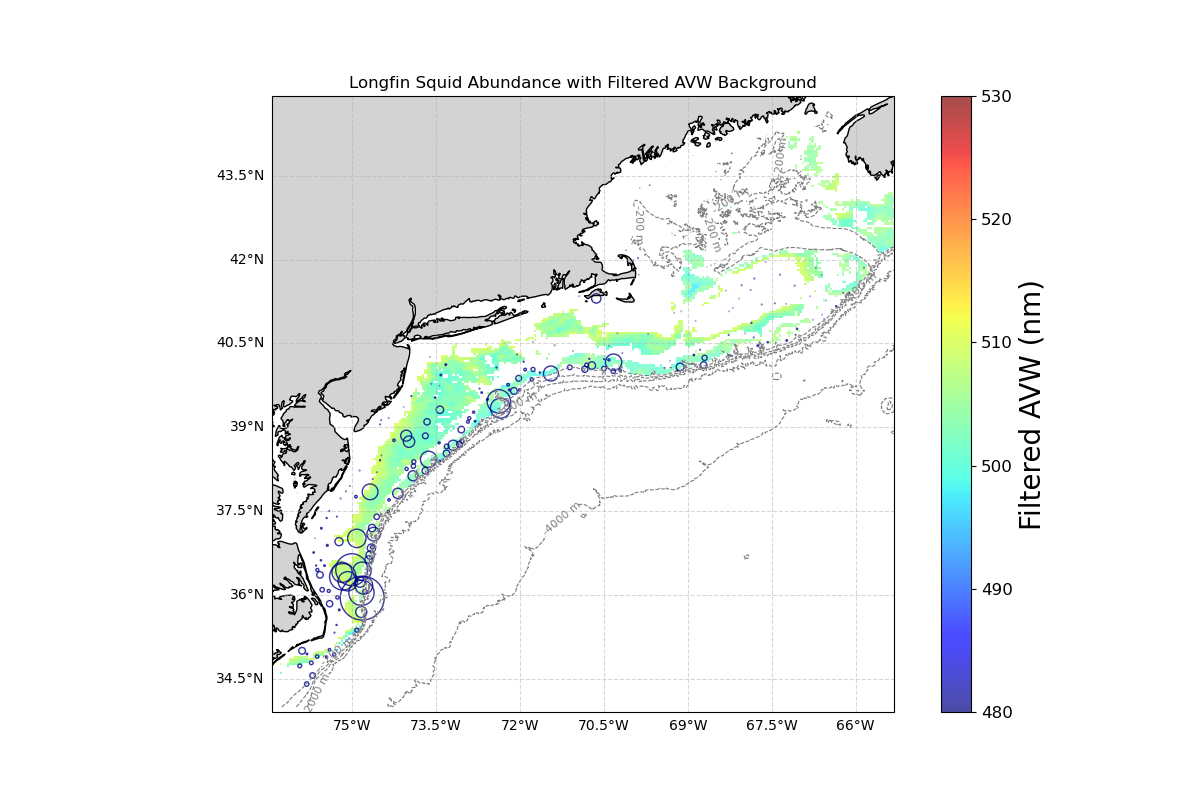

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Reuse your masks and filtered maps ===
PARz_log = np.log10(PARz)
avw_mask1 = (avw_subset >= 500) & (avw_subset <= 510)
brightness_mask1 = (PARz_log >= -1) & (PARz_log <= 1)
valid_mask1 = avw_mask1 & brightness_mask1

avw_mask2 = (avw_subset >= 490) & (avw_subset <= 507)
brightness_mask2 = (PARz_log >= -4.5) & (PARz_log <= -2)
valid_mask2 = avw_mask2 & brightness_mask2

avw_filtered1 = avw_subset.where(valid_mask1)
avw_filtered2 = avw_subset.where(valid_mask2)

# === Plot ===
fig = plt.figure(figsize=(12, 8))  # Match original figure size
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# === Plot the first layer (avw_filtered1) with colorbar ===
im1 = avw_filtered1.plot(
    ax=ax, 
    x='lon', 
    y='lat', 
    cmap='jet', 
    vmin=480, 
    vmax=530, 
    alpha=0.7, 
    add_colorbar=True,
    cbar_kwargs={'label': 'Filtered AVW (nm)'}
)

# === Customize colorbar for the first layer ===
cbar = im1.colorbar  # Access the colorbar from the first plot
cbar.set_label('Filtered AVW (nm)', fontsize=20)  # Adjust colorbar label font size
cbar.ax.tick_params(labelsize=12)  # Adjust colorbar ticks font size

# === Plot the second layer (avw_filtered2) ===
im2 = avw_filtered2.plot(
    ax=ax, 
    x='lon', 
    y='lat', 
    cmap='jet', 
    vmin=480, 
    vmax=530, 
    alpha=0.6,  # Adjust alpha to make the second layer semi-transparent
    add_colorbar=False  # Don't add a new colorbar for the second plot
)

# === Bathymetry Contours ===
contour_levels = [-4000, -2000, -1000, -500, -200]
cs = ax.contour(
    lon_bathy, lat_bathy, depth, 
    levels=contour_levels, colors='gray', linewidths=0.8, 
    transform=ccrs.PlateCarree()
)
ax.clabel(cs, inline=True, fontsize=8, fmt='%d m')

# === Coastlines and Land Feature ===
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# === Scatter Catches ===
scatter = ax.scatter(
    subset2["LON"], subset2["LAT"],
    s=sizes, facecolors='none', edgecolor='darkblue', 
    alpha=0.8, transform=ccrs.PlateCarree(),
    label=species.title()
)

# === Gridlines and Labels ===
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 10}  # Adjust gridline label size
gl.ylabel_style = {"size": 10}

# === Title ===
ax.set_title(f"{species.title()} Abundance with Filtered AVW Background")

# Save or show the plot
# plt.savefig(f"{species_filename}_filtered2.png", dpi=300)
plt.show()